<a href="https://colab.research.google.com/github/sobhanshukueian/Conditional-DCGAN/blob/main/cDCGAN_(Conditional_DCGAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cDCGAN(Conditional DCGAN)
A conditional generative adversarial network (CGAN) is a type of GAN that also takes advantage of labels during the training process.

* **Generator**: Given a label and uniform random variable array as input, and this network builds a mapping function from prior noise to our data space.

* **Discriminator**: Given batches of labeled data containing observations from both the training data and generated data from the generator, this network attempts return a single scalar representing the probability that x came form training data rather than generator distribution.

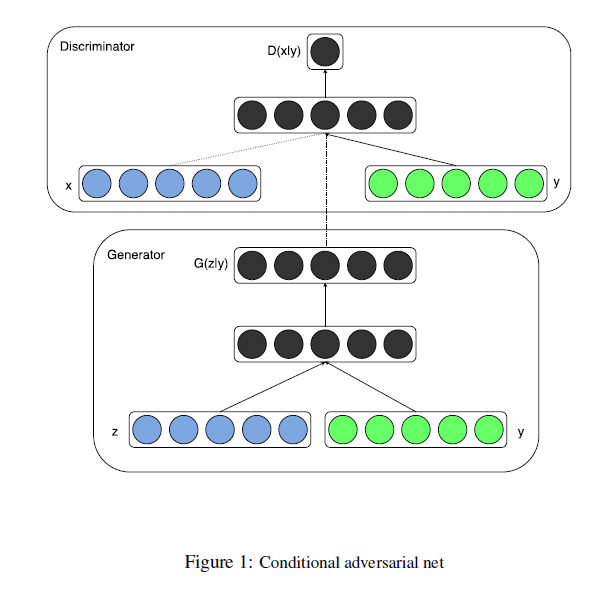

The goal of the generator is to fool the discriminator, so the generative neural network is trained to maximise the final classification error (between true and generated data)

The goal of the discriminator is to detect fake generated data, so the discriminative neural network is trained to minimise the final classification error

[Paper](https://arxiv.org/abs/1411.1784)

In [2]:
# %matplotlib inline
import numpy as np
import random
from PIL import Image
import PIL.ImageOps
import os
import shutil
import matplotlib
# matplotlib.use("TKAgg")
import matplotlib.pyplot as plt

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset
The MNIST database of handwritten digits has a training set of 60,000 examples and a test set of 10,000 samples.
I used pytorch datasets for downloading dataset : 
```
train_dataset = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('mnist/', train=False, download=True, transform=transform)
```

In [4]:
BATCH_SIZE = 16 #@param

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(
    'mnist/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(
    'mnist/', train=False, download=True, transform=transform)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



# Model

Below is a model architecture diagram for a Conditional DCGAN. Note that the high-level architecture is essentially the same as in the cGAN, except the Generator and Discriminator contain additional layers, such as Convolutions and Transposed Convolutions.

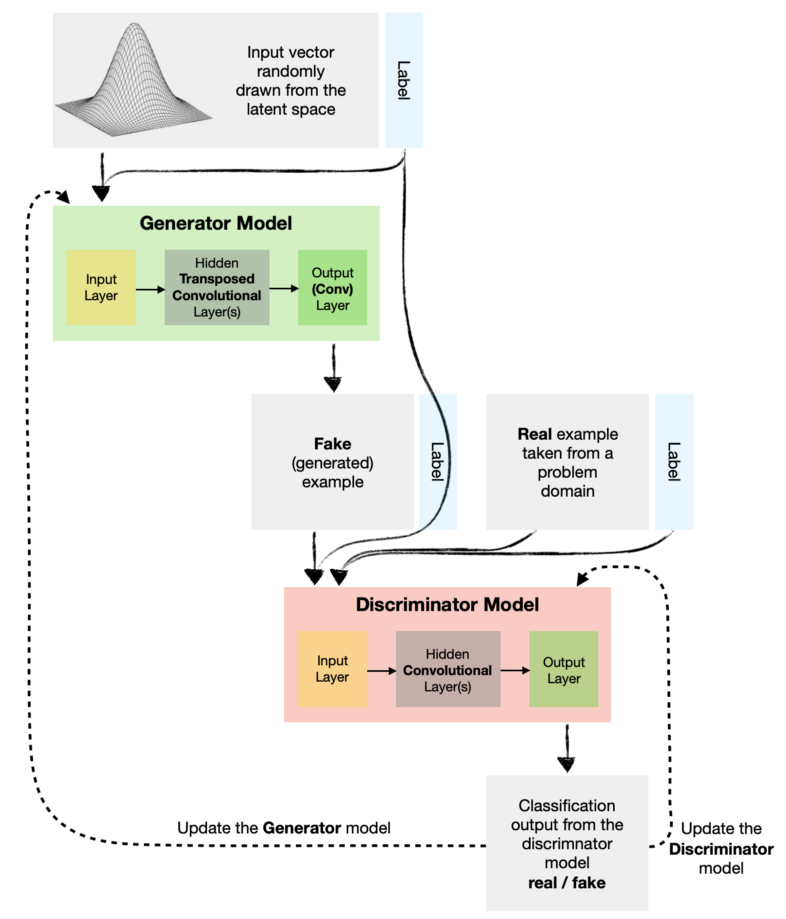

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear = nn.Sequential(nn.Linear(110, 7*7*128), nn.LeakyReLU())

        self.main = nn.Sequential(
            # 7,7
            
            nn.ConvTranspose2d(128, 20, kernel_size=5),  # 11, 11
            nn.BatchNorm2d(20),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(20, 20, kernel_size=4),  # 14, 14
            nn.BatchNorm2d(20),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(20, 20, kernel_size=4),  # 17, 17
            nn.BatchNorm2d(20),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(20, 20, kernel_size=4),  # 20, 20
            nn.BatchNorm2d(20),
            nn.ReLU(True),

            nn.ConvTranspose2d(20, 20, kernel_size=4),  # 23, 23
            nn.BatchNorm2d(20),
            nn.ReLU(True),

            nn.ConvTranspose2d(20, 20, kernel_size=3),  # 25, 25
            nn.BatchNorm2d(20),
            nn.ReLU(True),

            nn.ConvTranspose2d(20, 1, kernel_size=4),  # 28, 28

             nn.Tanh()
        )

    def forward(self, input, label):
        input = torch.concat([input , label], dim=1)
        # input shape 110
        input = self.linear(input) # 6,272
        
        input = input.view(input.size(0), 128, 7, 7)

        # print(input.shape)
        return self.main(input)


tst = torch.rand(size=(64, 100))
lbl = torch.rand(size=(64, 10))

genereator = Generator()
x = genereator(tst, lbl)
x.shape


torch.Size([64, 1, 28, 28])

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear = nn.Sequential(nn.Linear(10, 7*7*16), nn.LeakyReLU())

        
        self.main = nn.Sequential(
            nn.Conv2d(2, 20, kernel_size=3), #26
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(20, 30, kernel_size=3), #24
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2),#12
            nn.Conv2d(30, 30, kernel_size=3), #10
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2), #5
            nn.Conv2d(30, 20, kernel_size=3), #3
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(20, 1, kernel_size=3), #1
            nn.Sigmoid()
        )
        self.flat = nn.Flatten()

    def forward(self, images, label):
        label = self.linear(label).view(label.size(0), 1, 28, 28)
        output = torch.concat([images, label], dim=1)
        output = self.main(output)
        output = self.flat(output)
        return output

label = torch.rand(size=(64, 10))
imgs = torch.rand(size=(64, 1, 28, 28))

dis = Discriminator()
x = dis(imgs, label)
x.shape

torch.Size([64, 1])


# Train
Trainer class Does the main part of code which is training model, plot the training process and save model each n epochs.

I Defined `Adam` Optimizer with learning rate 0.0002.

Each generative model training step occurse in `train_generator` function, descriminator model training step in `train_descriminator` and whole trining process in 
`train` function.

## Some Configurations
 
*   You can set epoch size : `EPOCHS` and batch size : `BATCH_SIZE`.
*   Set `device` that you want to train model on it : `device`(default runs on cuda if it's available)
*   You can set one of three `verboses` that prints info you want => 0 == nothing || 1 == model architecture || 2 == print optimizer || 3 == model parameters size.
*   Each time you train model weights and plot(if `save_plots` == True) will be saved in `save_dir`.
*   You can find a `configs` file in `save_dir` that contains some information about run. 
*   You can choose Optimizer: `OPTIMIZER` 

# Loss Function

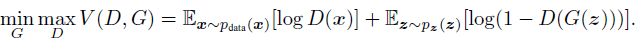

In [8]:
#@title Some Configurations
EPOCHS = 200 #@param {type:"integer"}
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' #@param
VERBOSE = 3 #@param [0, 1, 2, 3] {type:"raw"}
SAVE_PLOTS = True #@param {type:"boolean"}
VISUALIZE_PLOTS = True #@param {type:"boolean"}
SAVE_DIR = "./runs" #@param
MODEL_NAME = "MNIST cDCGAN Implementation" #@param
OPTIMIZER = "Adam" #@param ["Adam", "SGD"] {type:"raw"}


Generator Model: Generator(
  (linear): Sequential(
    (0): Linear(in_features=110, out_features=6272, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (main): Sequential(
    (0): ConvTranspose2d(128, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(20, 20, kernel_size=(4, 4), stride=(1, 1))
    (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(20, 20, kernel_size=(4, 4), stride=(1, 1))
    (7): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(20, 20, kernel_size=(4, 4), stride=(1, 1))
    (10): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(20, 20, kernel_size=(4, 4), stride=(1, 1))
    (13

Epoch: 0/200	Descriminator Loss: 0.6835695505142212\Generator Loss: 0.7201739549636841: 100%|██████████| 3750/3750 [01:48<00:00, 34.60it/s]


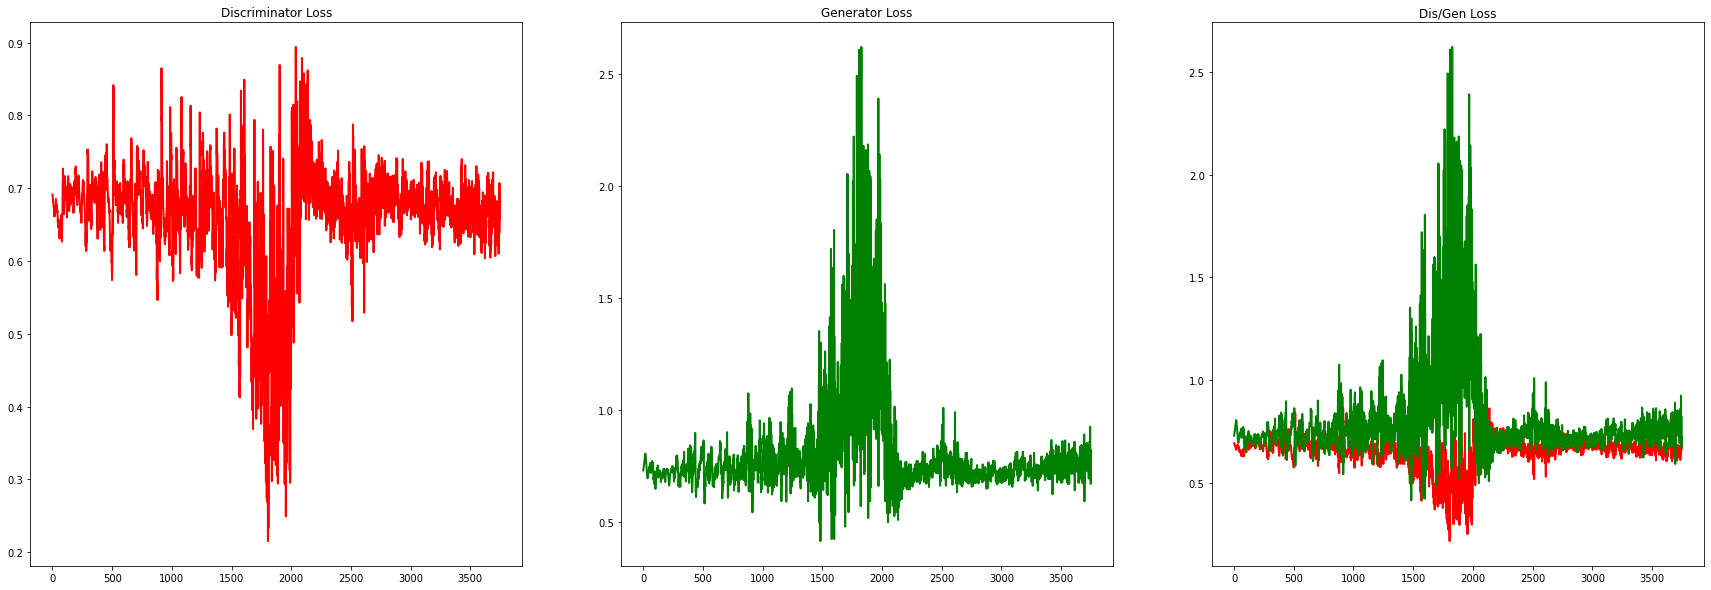

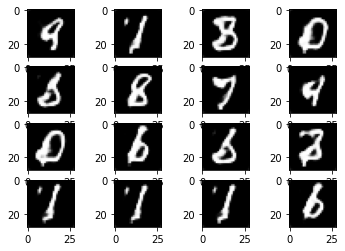

tensor([4, 1, 3, 0, 5, 8, 7, 4, 0, 6, 5, 2, 1, 1, 1, 6], device='cuda:0')


Epoch: 1/200	Descriminator Loss: 0.5572242736816406\Generator Loss: 0.9469825029373169: 100%|██████████| 3750/3750 [01:48<00:00, 34.64it/s]
Epoch: 2/200	Descriminator Loss: 0.6338318586349487\Generator Loss: 0.9275997877120972: 100%|██████████| 3750/3750 [01:42<00:00, 36.76it/s]
Epoch: 3/200	Descriminator Loss: 0.4006248712539673\Generator Loss: 1.2743910551071167: 100%|██████████| 3750/3750 [01:41<00:00, 36.97it/s]
Epoch: 4/200	Descriminator Loss: 0.5414556264877319\Generator Loss: 1.2350116968154907: 100%|██████████| 3750/3750 [01:41<00:00, 36.85it/s]
Epoch: 5/200	Descriminator Loss: 0.6424987316131592\Generator Loss: 1.2160921096801758: 100%|██████████| 3750/3750 [01:39<00:00, 37.52it/s]
Epoch: 6/200	Descriminator Loss: 0.6585345268249512\Generator Loss: 0.9256854057312012: 100%|██████████| 3750/3750 [01:41<00:00, 37.04it/s]
Epoch: 7/200	Descriminator Loss: 0.7119073867797852\Generator Loss: 1.7596163749694824: 100%|██████████| 3750/3750 [01:41<00:00, 37.05it/s]
Epoch: 8/200	Descrim

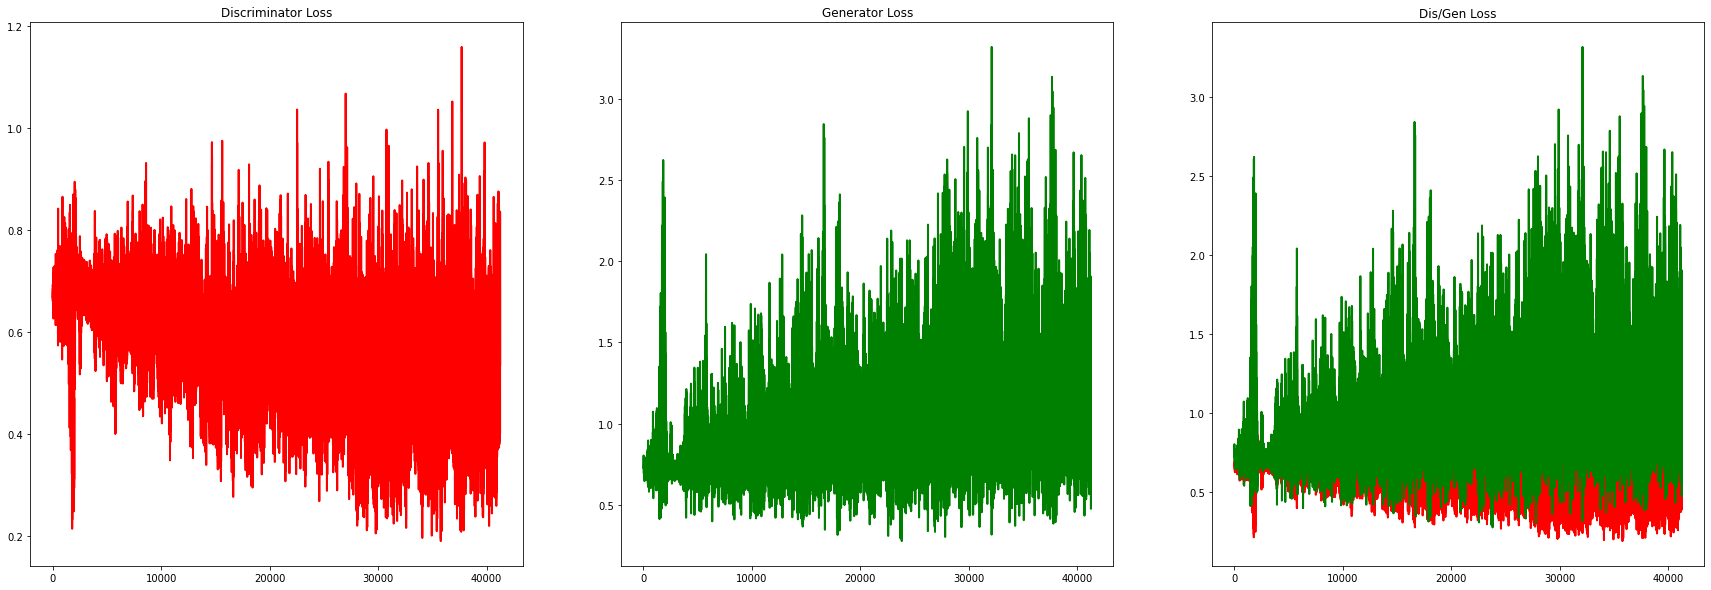

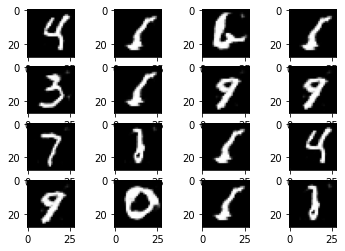

tensor([4, 8, 6, 8, 3, 8, 9, 9, 7, 1, 8, 4, 9, 0, 8, 1], device='cuda:0')


Epoch: 11/200	Descriminator Loss: 0.5670302510261536\Generator Loss: 1.378235101699829: 100%|██████████| 3750/3750 [01:40<00:00, 37.42it/s]
Epoch: 12/200	Descriminator Loss: 0.33771994709968567\Generator Loss: 1.6427404880523682: 100%|██████████| 3750/3750 [01:41<00:00, 37.06it/s]
Epoch: 13/200	Descriminator Loss: 0.49979740381240845\Generator Loss: 1.3334094285964966: 100%|██████████| 3750/3750 [01:42<00:00, 36.63it/s]
Epoch: 14/200	Descriminator Loss: 0.26915064454078674\Generator Loss: 2.0653021335601807: 100%|██████████| 3750/3750 [01:41<00:00, 36.87it/s]
Epoch: 15/200	Descriminator Loss: 0.9581472277641296\Generator Loss: 0.5048738121986389: 100%|██████████| 3750/3750 [01:41<00:00, 36.93it/s]
Epoch: 16/200	Descriminator Loss: 0.6672754287719727\Generator Loss: 1.0445523262023926: 100%|██████████| 3750/3750 [01:41<00:00, 37.06it/s]
Epoch: 17/200	Descriminator Loss: 0.3136626183986664\Generator Loss: 1.5627408027648926: 100%|██████████| 3750/3750 [01:40<00:00, 37.14it/s]
Epoch: 18/2

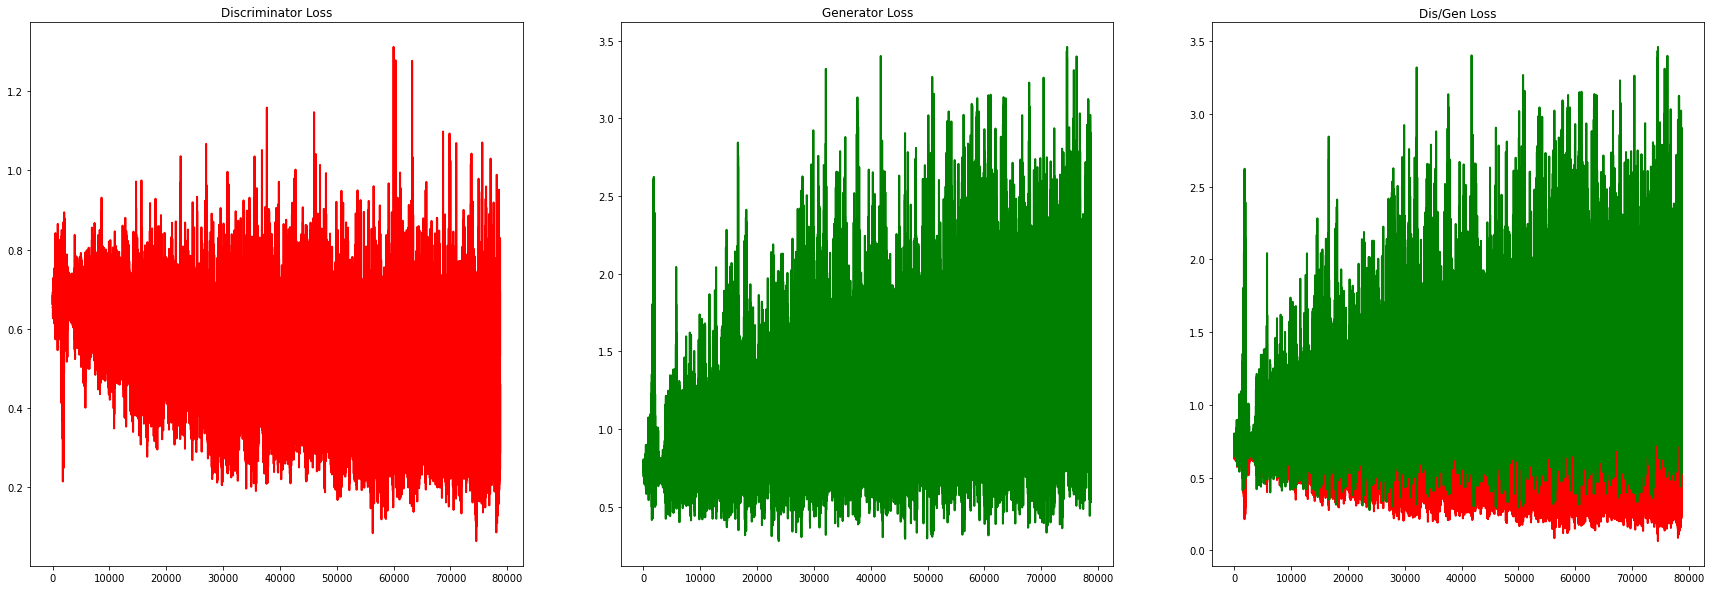

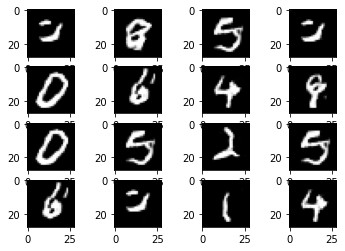

tensor([7, 8, 5, 7, 0, 6, 4, 9, 0, 5, 2, 5, 6, 7, 1, 4], device='cuda:0')


Epoch: 21/200	Descriminator Loss: 0.37525254487991333\Generator Loss: 1.1618053913116455: 100%|██████████| 3750/3750 [01:42<00:00, 36.65it/s]
Epoch: 22/200	Descriminator Loss: 0.5073341131210327\Generator Loss: 1.2646688222885132: 100%|██████████| 3750/3750 [01:42<00:00, 36.47it/s]
Epoch: 23/200	Descriminator Loss: 0.44520536065101624\Generator Loss: 1.3202860355377197: 100%|██████████| 3750/3750 [01:42<00:00, 36.52it/s]
Epoch: 24/200	Descriminator Loss: 0.4194534420967102\Generator Loss: 1.2325931787490845: 100%|██████████| 3750/3750 [01:42<00:00, 36.56it/s]
Epoch: 25/200	Descriminator Loss: 0.31762295961380005\Generator Loss: 1.6318104267120361: 100%|██████████| 3750/3750 [01:43<00:00, 36.22it/s]
Epoch: 26/200	Descriminator Loss: 0.18675333261489868\Generator Loss: 2.0293333530426025: 100%|██████████| 3750/3750 [01:43<00:00, 36.07it/s]
Epoch: 27/200	Descriminator Loss: 0.4368645250797272\Generator Loss: 1.3121845722198486: 100%|██████████| 3750/3750 [01:44<00:00, 35.91it/s]
Epoch: 28

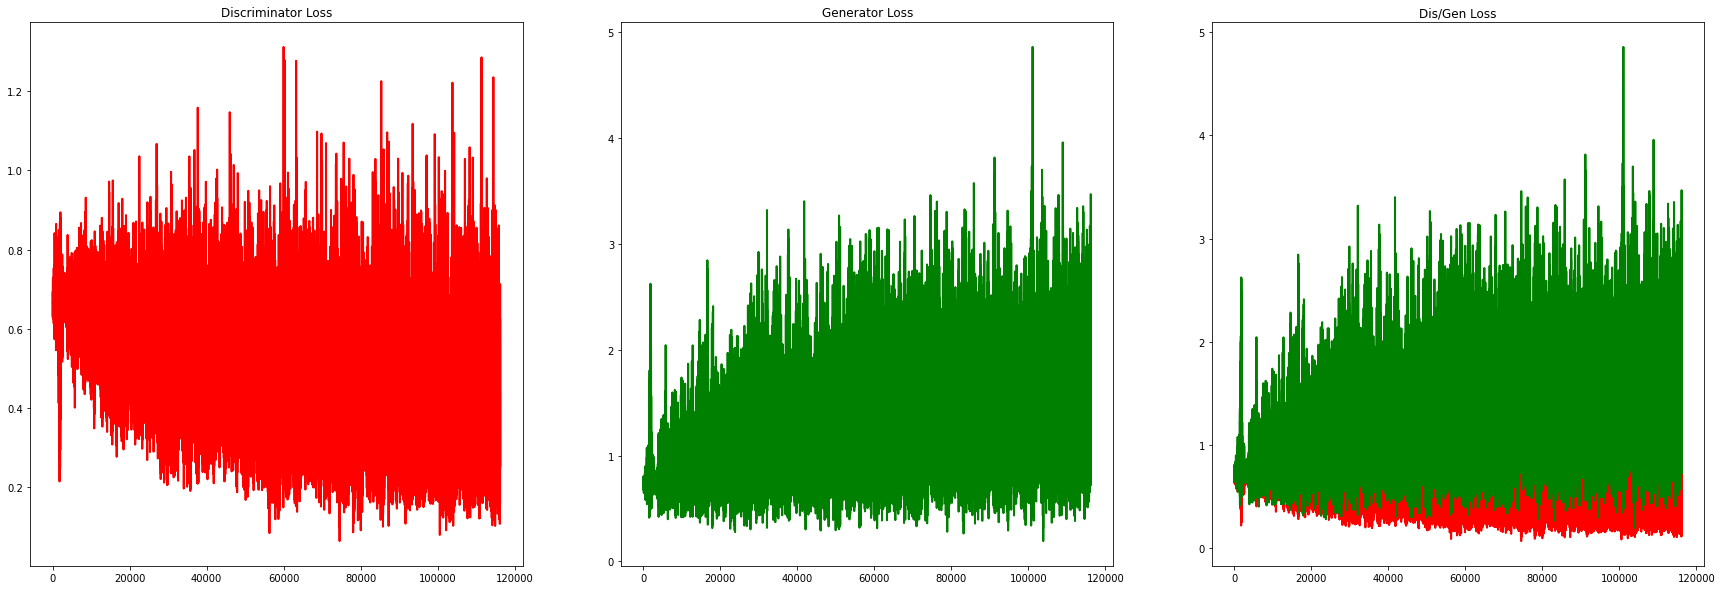

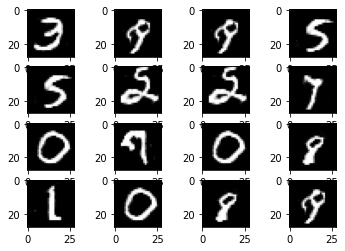

tensor([3, 9, 9, 5, 5, 2, 2, 7, 0, 4, 0, 8, 1, 0, 8, 9], device='cuda:0')


Epoch: 31/200	Descriminator Loss: 0.30538129806518555\Generator Loss: 1.975567102432251: 100%|██████████| 3750/3750 [01:43<00:00, 36.09it/s]
Epoch: 32/200	Descriminator Loss: 0.6471765637397766\Generator Loss: 1.4979979991912842: 100%|██████████| 3750/3750 [01:43<00:00, 36.17it/s]
Epoch: 33/200	Descriminator Loss: 0.2701050043106079\Generator Loss: 2.1646156311035156: 100%|██████████| 3750/3750 [01:44<00:00, 36.02it/s]
Epoch: 34/200	Descriminator Loss: 0.5002999305725098\Generator Loss: 1.1860382556915283: 100%|██████████| 3750/3750 [01:44<00:00, 35.99it/s]
Epoch: 35/200	Descriminator Loss: 0.26381921768188477\Generator Loss: 1.8632116317749023: 100%|██████████| 3750/3750 [01:45<00:00, 35.61it/s]
Epoch: 36/200	Descriminator Loss: 0.20389413833618164\Generator Loss: 2.1365394592285156: 100%|██████████| 3750/3750 [01:45<00:00, 35.65it/s]
Epoch: 37/200	Descriminator Loss: 0.4385550916194916\Generator Loss: 2.2642064094543457: 100%|██████████| 3750/3750 [01:45<00:00, 35.65it/s]
Epoch: 38/2

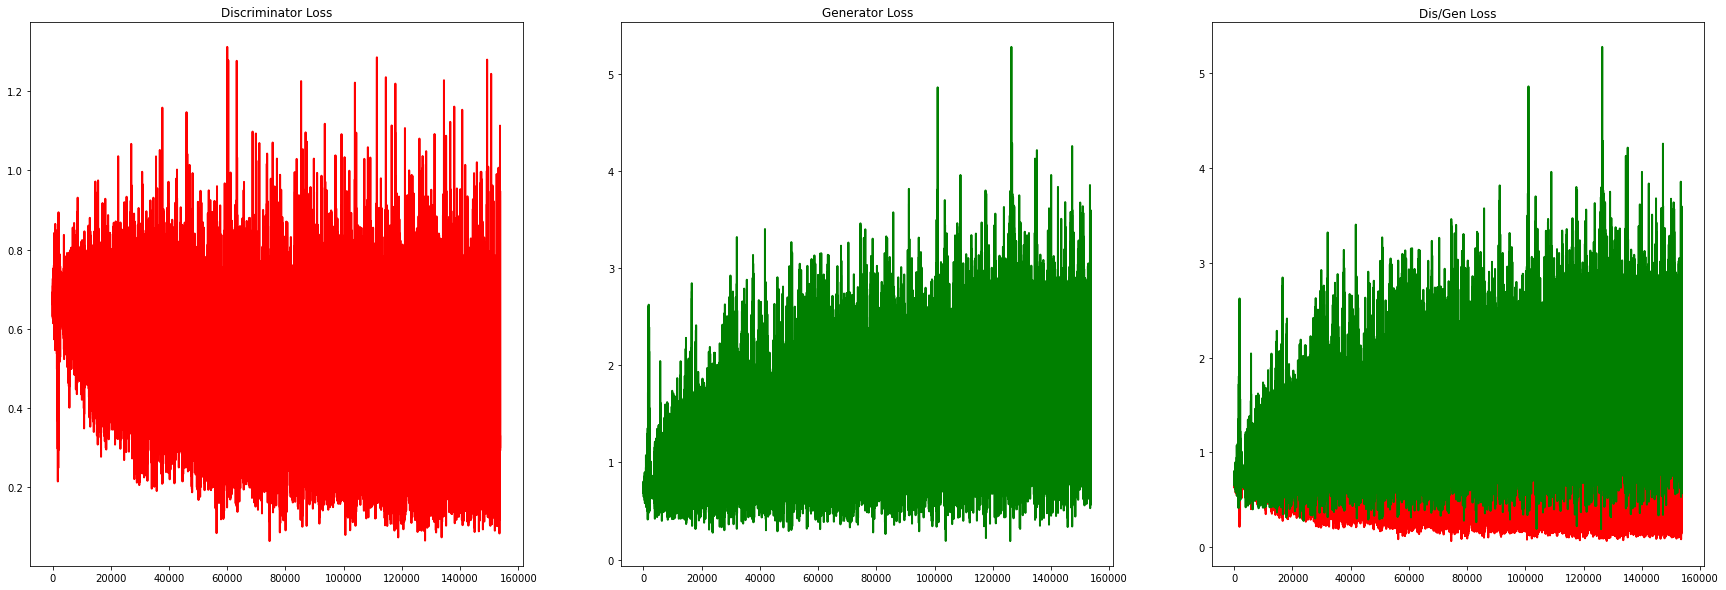

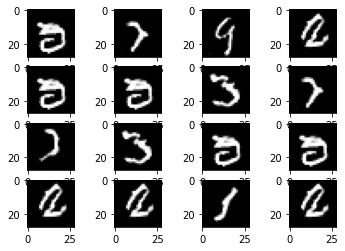

tensor([8, 7, 9, 6, 8, 8, 3, 7, 2, 3, 8, 8, 6, 6, 1, 6], device='cuda:0')


Epoch: 41/200	Descriminator Loss: 0.11023321747779846\Generator Loss: 2.5530643463134766: 100%|██████████| 3750/3750 [01:45<00:00, 35.38it/s]
Epoch: 42/200	Descriminator Loss: 0.4637838304042816\Generator Loss: 1.7634613513946533: 100%|██████████| 3750/3750 [01:46<00:00, 35.31it/s]
Epoch: 43/200	Descriminator Loss: 0.2194448709487915\Generator Loss: 2.3128771781921387: 100%|██████████| 3750/3750 [01:46<00:00, 35.20it/s]
Epoch: 44/200	Descriminator Loss: 0.2467362880706787\Generator Loss: 2.1278085708618164: 100%|██████████| 3750/3750 [01:46<00:00, 35.34it/s]
Epoch: 45/200	Descriminator Loss: 0.24109138548374176\Generator Loss: 1.744126319885254: 100%|██████████| 3750/3750 [01:45<00:00, 35.54it/s]
Epoch: 46/200	Descriminator Loss: 0.7872196435928345\Generator Loss: 0.929191529750824: 100%|██████████| 3750/3750 [01:44<00:00, 35.77it/s]
Epoch: 47/200	Descriminator Loss: 0.6236425638198853\Generator Loss: 1.117414951324463: 100%|██████████| 3750/3750 [01:45<00:00, 35.67it/s]
Epoch: 48/200	

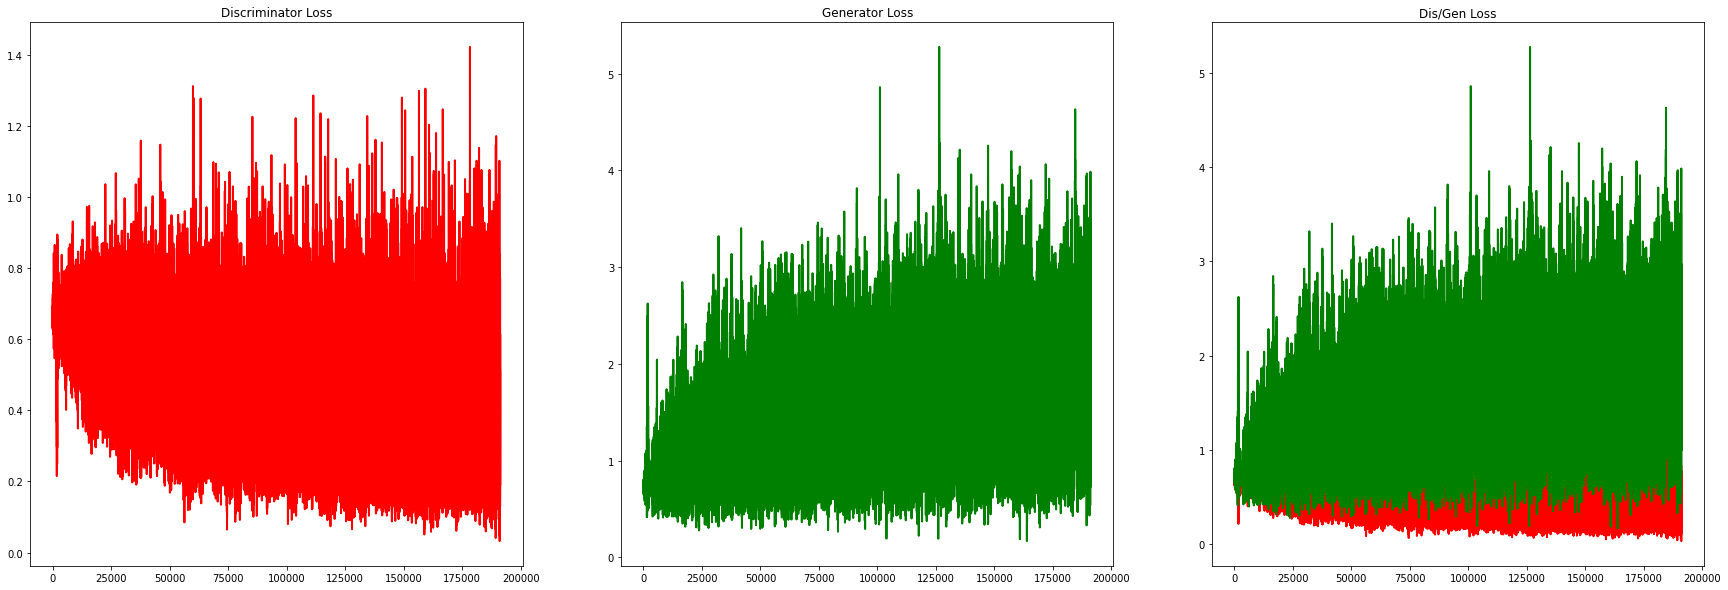

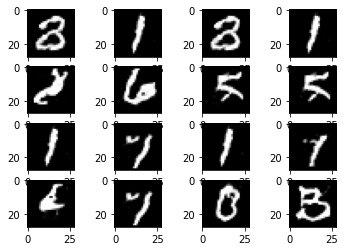

tensor([8, 1, 8, 1, 2, 6, 5, 5, 1, 7, 1, 9, 4, 7, 0, 3], device='cuda:0')


Epoch: 51/200	Descriminator Loss: 0.5024927854537964\Generator Loss: 1.7870826721191406: 100%|██████████| 3750/3750 [01:46<00:00, 35.27it/s]
Epoch: 52/200	Descriminator Loss: 0.2071187049150467\Generator Loss: 2.7422077655792236: 100%|██████████| 3750/3750 [01:47<00:00, 35.04it/s]
Epoch: 53/200	Descriminator Loss: 0.3438393175601959\Generator Loss: 1.9592552185058594: 100%|██████████| 3750/3750 [01:47<00:00, 34.95it/s]
Epoch: 54/200	Descriminator Loss: 0.43293309211730957\Generator Loss: 1.7416101694107056: 100%|██████████| 3750/3750 [01:47<00:00, 34.94it/s]
Epoch: 55/200	Descriminator Loss: 0.23239868879318237\Generator Loss: 1.816028356552124: 100%|██████████| 3750/3750 [01:46<00:00, 35.07it/s]
Epoch: 56/200	Descriminator Loss: 0.34964925050735474\Generator Loss: 2.0562362670898438: 100%|██████████| 3750/3750 [01:49<00:00, 34.26it/s]
Epoch: 57/200	Descriminator Loss: 0.37163636088371277\Generator Loss: 1.5947620868682861: 100%|██████████| 3750/3750 [01:49<00:00, 34.19it/s]
Epoch: 58/

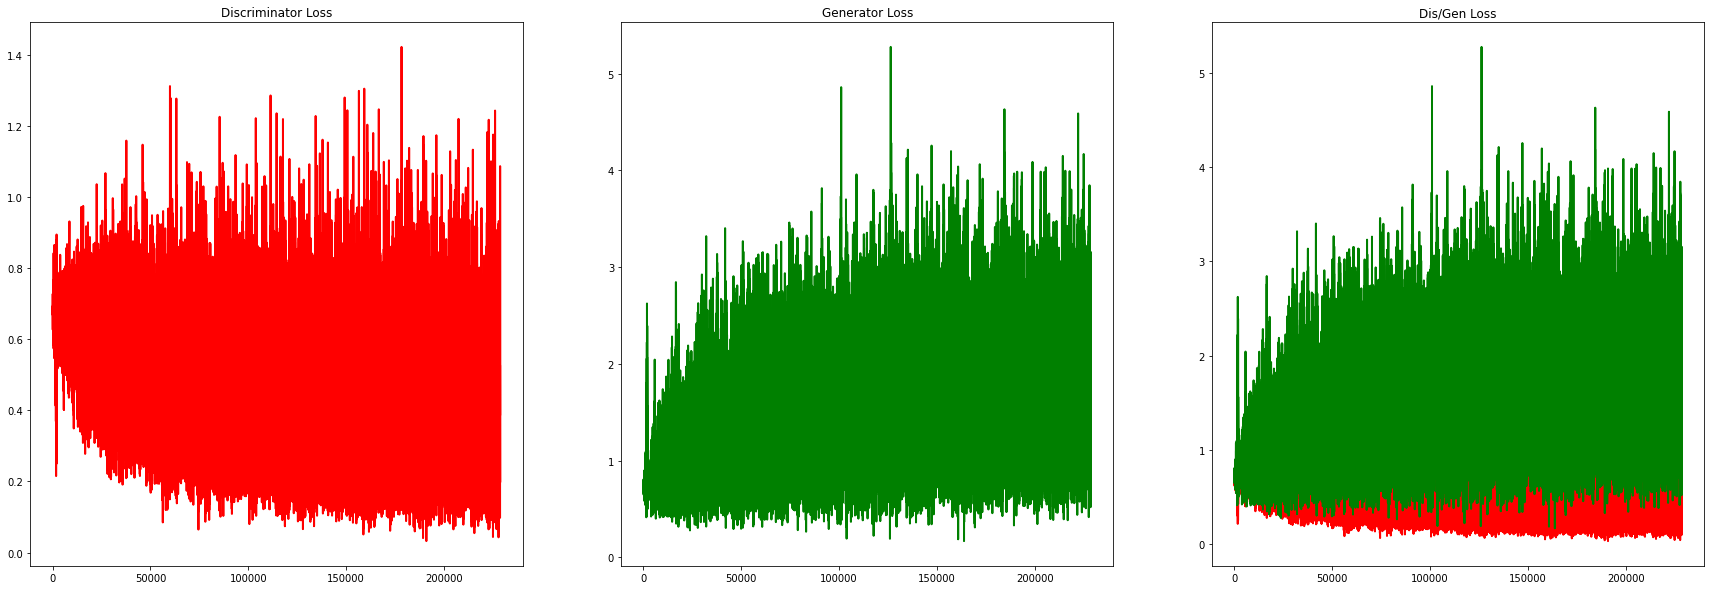

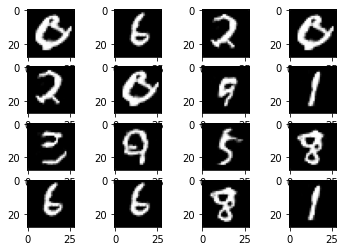

tensor([0, 6, 2, 0, 2, 0, 7, 1, 3, 4, 5, 8, 6, 6, 8, 1], device='cuda:0')


Epoch: 61/200	Descriminator Loss: 0.4930999279022217\Generator Loss: 1.12497079372406: 100%|██████████| 3750/3750 [01:48<00:00, 34.64it/s]
Epoch: 62/200	Descriminator Loss: 0.42167574167251587\Generator Loss: 1.585972785949707: 100%|██████████| 3750/3750 [01:50<00:00, 33.93it/s]
Epoch: 63/200	Descriminator Loss: 0.35036152601242065\Generator Loss: 1.6963878870010376: 100%|██████████| 3750/3750 [01:50<00:00, 33.81it/s]
Epoch: 64/200	Descriminator Loss: 0.21553030610084534\Generator Loss: 2.77535343170166: 100%|██████████| 3750/3750 [01:50<00:00, 33.94it/s]
Epoch: 65/200	Descriminator Loss: 0.4539647698402405\Generator Loss: 1.9029343128204346: 100%|██████████| 3750/3750 [01:50<00:00, 33.81it/s]
Epoch: 66/200	Descriminator Loss: 0.13356082141399384\Generator Loss: 2.103814125061035: 100%|██████████| 3750/3750 [01:51<00:00, 33.60it/s]
Epoch: 67/200	Descriminator Loss: 0.3117521405220032\Generator Loss: 2.0665054321289062: 100%|██████████| 3750/3750 [01:50<00:00, 33.86it/s]
Epoch: 68/200	D

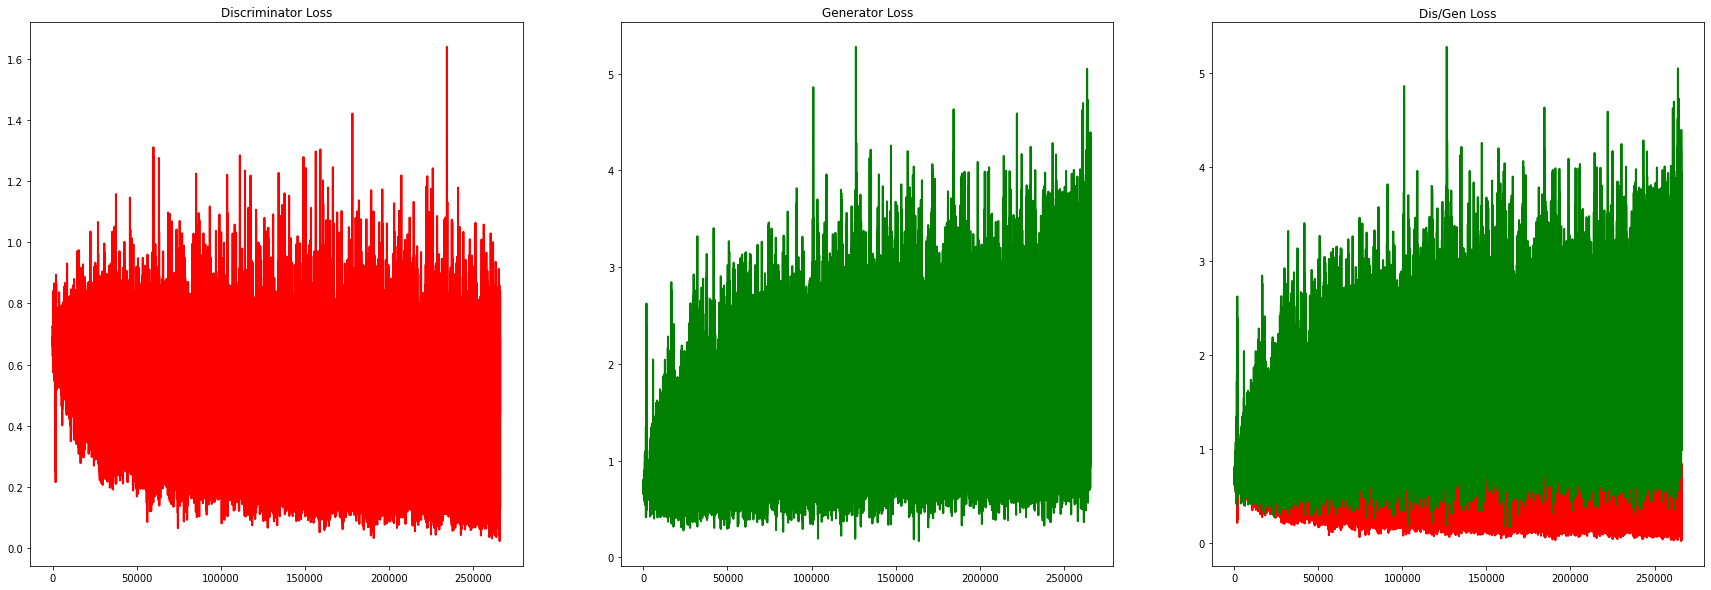

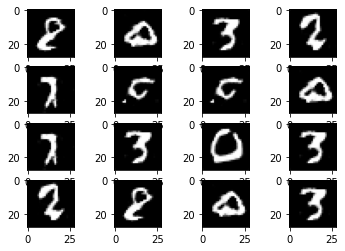

tensor([8, 6, 3, 2, 7, 5, 5, 6, 7, 3, 0, 3, 2, 8, 6, 3], device='cuda:0')


Epoch: 71/200	Descriminator Loss: 0.08044396340847015\Generator Loss: 2.9010634422302246: 100%|██████████| 3750/3750 [01:54<00:00, 32.78it/s]
Epoch: 72/200	Descriminator Loss: 0.21965664625167847\Generator Loss: 2.3207154273986816: 100%|██████████| 3750/3750 [01:54<00:00, 32.66it/s]
Epoch: 73/200	Descriminator Loss: 0.35230857133865356\Generator Loss: 2.5496959686279297: 100%|██████████| 3750/3750 [01:56<00:00, 32.18it/s]
Epoch: 74/200	Descriminator Loss: 0.14870598912239075\Generator Loss: 2.710763454437256: 100%|██████████| 3750/3750 [01:56<00:00, 32.11it/s]
Epoch: 75/200	Descriminator Loss: 0.205125093460083\Generator Loss: 2.30192232131958: 100%|██████████| 3750/3750 [01:54<00:00, 32.61it/s]
Epoch: 76/200	Descriminator Loss: 0.41137123107910156\Generator Loss: 2.15071439743042: 100%|██████████| 3750/3750 [01:51<00:00, 33.57it/s]
Epoch: 77/200	Descriminator Loss: 0.38754141330718994\Generator Loss: 1.395627737045288: 100%|██████████| 3750/3750 [01:50<00:00, 33.86it/s]
Epoch: 78/200	

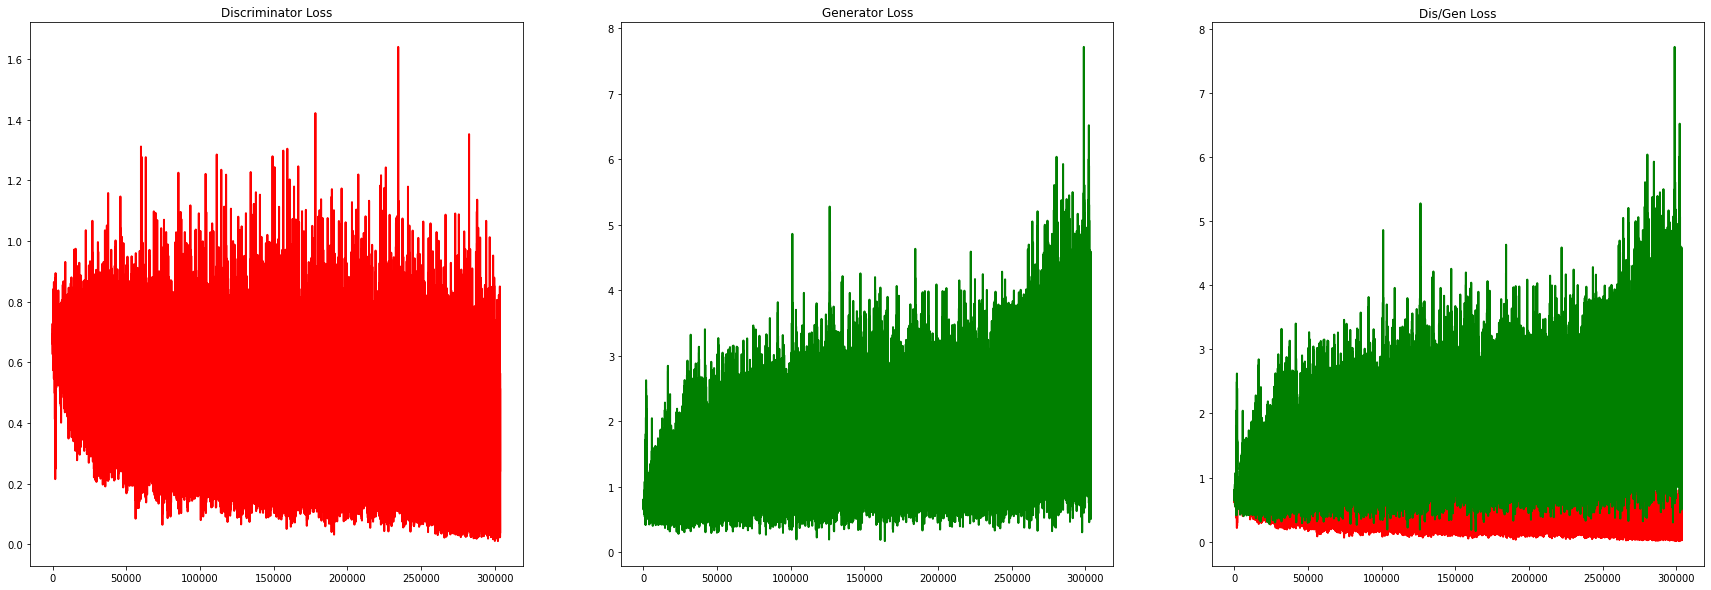

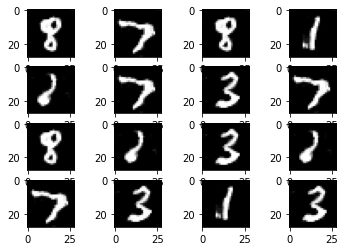

tensor([8, 7, 8, 1, 2, 7, 3, 7, 8, 2, 3, 2, 7, 3, 1, 3], device='cuda:0')


Epoch: 81/200	Descriminator Loss: 0.23175664246082306\Generator Loss: 2.9652652740478516: 100%|██████████| 3750/3750 [01:51<00:00, 33.56it/s]
Epoch: 82/200	Descriminator Loss: 0.0802689790725708\Generator Loss: 3.4937613010406494: 100%|██████████| 3750/3750 [01:51<00:00, 33.57it/s]
Epoch: 83/200	Descriminator Loss: 0.26337674260139465\Generator Loss: 2.1628012657165527: 100%|██████████| 3750/3750 [01:51<00:00, 33.51it/s]
Epoch: 84/200	Descriminator Loss: 0.030006248503923416\Generator Loss: 3.829166889190674: 100%|██████████| 3750/3750 [01:50<00:00, 33.96it/s]
Epoch: 85/200	Descriminator Loss: 0.17512914538383484\Generator Loss: 3.3120198249816895: 100%|██████████| 3750/3750 [01:50<00:00, 33.95it/s]
Epoch: 86/200	Descriminator Loss: 0.146737203001976\Generator Loss: 4.370326995849609: 100%|██████████| 3750/3750 [01:50<00:00, 33.93it/s]
Epoch: 87/200	Descriminator Loss: 0.19777461886405945\Generator Loss: 3.808333396911621: 100%|██████████| 3750/3750 [01:50<00:00, 33.99it/s]
Epoch: 88/2

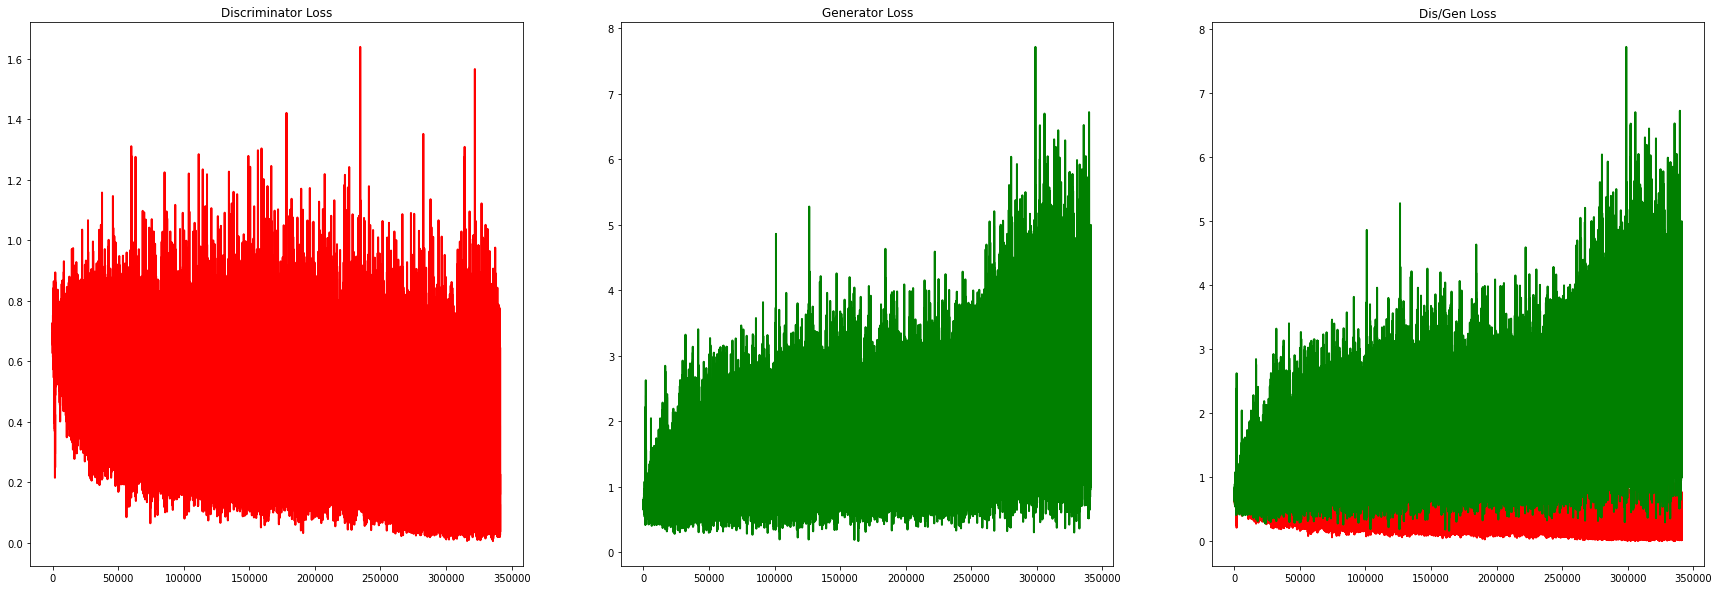

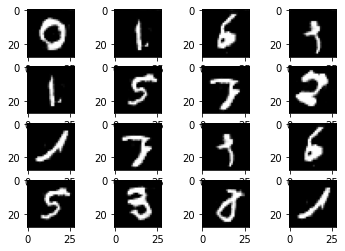

tensor([0, 1, 6, 9, 1, 5, 7, 2, 4, 7, 9, 6, 5, 3, 8, 4], device='cuda:0')


Epoch: 91/200	Descriminator Loss: 0.10536497831344604\Generator Loss: 4.199577331542969: 100%|██████████| 3750/3750 [01:52<00:00, 33.21it/s]
Epoch: 92/200	Descriminator Loss: 0.18548111617565155\Generator Loss: 3.582822799682617: 100%|██████████| 3750/3750 [01:52<00:00, 33.23it/s]
Epoch: 93/200	Descriminator Loss: 0.1272859275341034\Generator Loss: 3.0328595638275146: 100%|██████████| 3750/3750 [01:52<00:00, 33.44it/s]
Epoch: 94/200	Descriminator Loss: 0.04089602082967758\Generator Loss: 4.008844375610352: 100%|██████████| 3750/3750 [01:51<00:00, 33.58it/s]
Epoch: 95/200	Descriminator Loss: 0.03752315416932106\Generator Loss: 3.4611854553222656: 100%|██████████| 3750/3750 [01:54<00:00, 32.76it/s]
Epoch: 96/200	Descriminator Loss: 0.23375320434570312\Generator Loss: 2.7614190578460693: 100%|██████████| 3750/3750 [01:55<00:00, 32.50it/s]
Epoch: 97/200	Descriminator Loss: 0.06006528437137604\Generator Loss: 2.744619607925415: 100%|██████████| 3750/3750 [01:55<00:00, 32.57it/s]
Epoch: 98/2

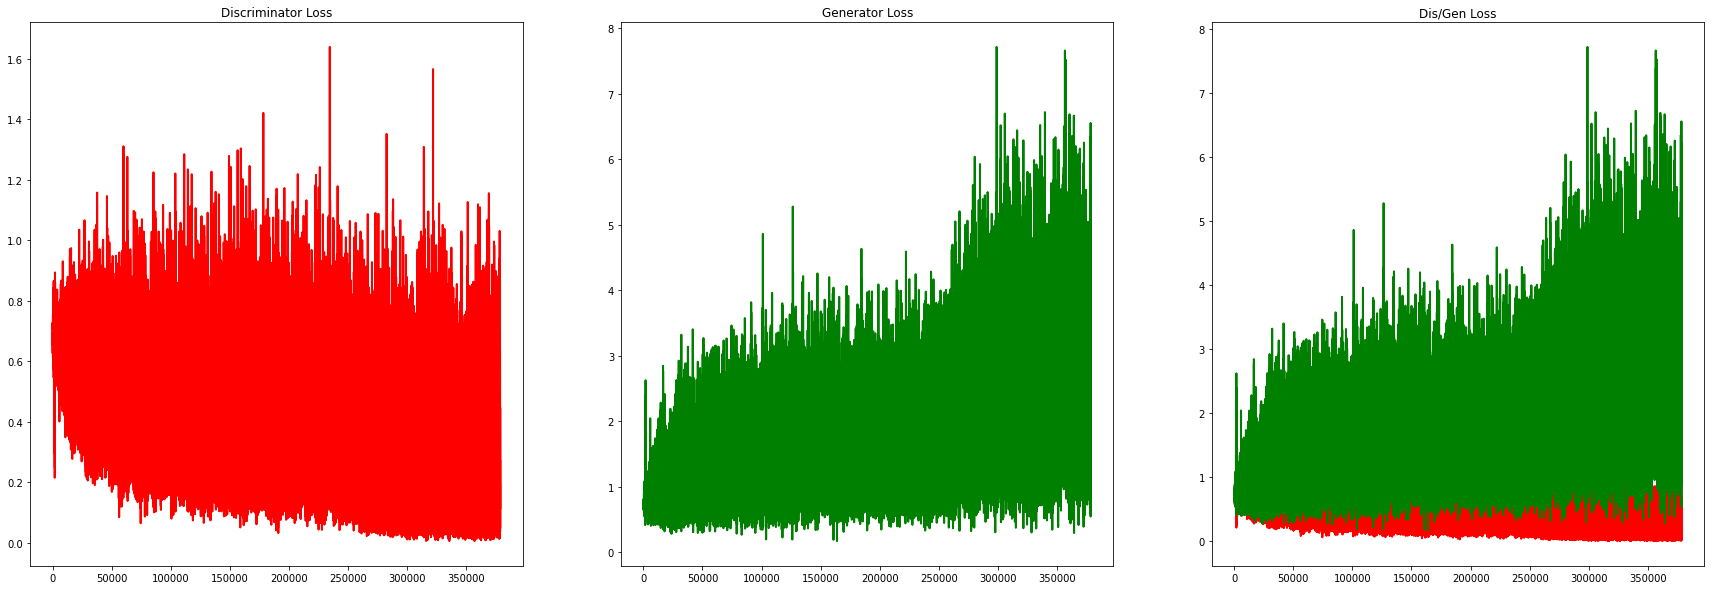

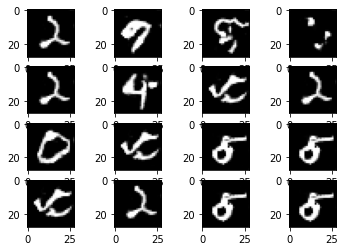

tensor([2, 7, 8, 1, 2, 4, 6, 2, 0, 6, 5, 5, 6, 2, 5, 5], device='cuda:0')


Epoch: 101/200	Descriminator Loss: 0.11551555246114731\Generator Loss: 2.836137056350708: 100%|██████████| 3750/3750 [01:53<00:00, 33.16it/s]
Epoch: 102/200	Descriminator Loss: 0.14727357029914856\Generator Loss: 2.5726399421691895: 100%|██████████| 3750/3750 [01:52<00:00, 33.24it/s]
Epoch: 103/200	Descriminator Loss: 0.12205023318529129\Generator Loss: 2.543315887451172: 100%|██████████| 3750/3750 [01:55<00:00, 32.48it/s]
Epoch: 104/200	Descriminator Loss: 0.13884404301643372\Generator Loss: 3.6818599700927734: 100%|██████████| 3750/3750 [01:56<00:00, 32.27it/s]
Epoch: 105/200	Descriminator Loss: 0.4735131561756134\Generator Loss: 1.1621369123458862: 100%|██████████| 3750/3750 [01:56<00:00, 32.31it/s]
Epoch: 106/200	Descriminator Loss: 0.3279397189617157\Generator Loss: 4.0733232498168945: 100%|██████████| 3750/3750 [01:54<00:00, 32.74it/s]
Epoch: 107/200	Descriminator Loss: 0.1621844470500946\Generator Loss: 7.334003448486328: 100%|██████████| 3750/3750 [01:54<00:00, 32.87it/s]
Epoch

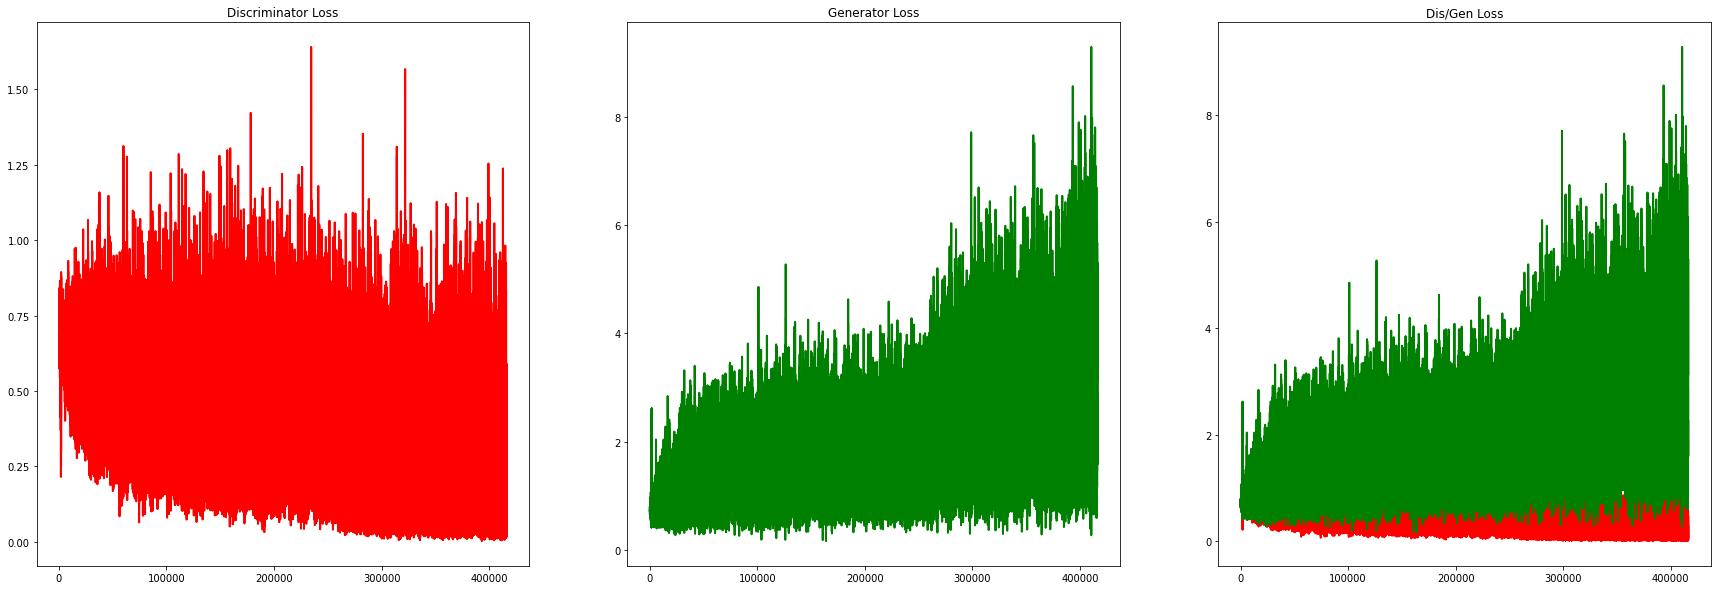

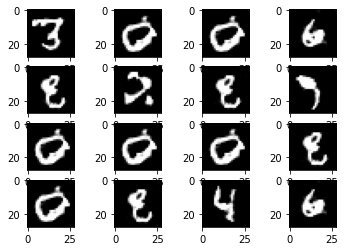

tensor([3, 0, 0, 6, 8, 2, 8, 7, 0, 0, 0, 8, 0, 8, 4, 6], device='cuda:0')


Epoch: 111/200	Descriminator Loss: 0.17446190118789673\Generator Loss: 3.026277780532837: 100%|██████████| 3750/3750 [01:54<00:00, 32.67it/s]
Epoch: 112/200	Descriminator Loss: 0.15331605076789856\Generator Loss: 2.954606533050537: 100%|██████████| 3750/3750 [01:54<00:00, 32.65it/s]
Epoch: 113/200	Descriminator Loss: 0.3135564923286438\Generator Loss: 2.1762990951538086: 100%|██████████| 3750/3750 [01:54<00:00, 32.89it/s]
Epoch: 114/200	Descriminator Loss: 0.3612159490585327\Generator Loss: 3.1104578971862793: 100%|██████████| 3750/3750 [01:53<00:00, 33.08it/s]
Epoch: 115/200	Descriminator Loss: 0.26384857296943665\Generator Loss: 2.6937384605407715: 100%|██████████| 3750/3750 [01:56<00:00, 32.16it/s]
Epoch: 116/200	Descriminator Loss: 0.22015976905822754\Generator Loss: 2.602184295654297: 100%|██████████| 3750/3750 [01:58<00:00, 31.52it/s]
Epoch: 117/200	Descriminator Loss: 0.3342064619064331\Generator Loss: 3.741769790649414: 100%|██████████| 3750/3750 [01:57<00:00, 31.83it/s]
Epoch:

In [ ]:
import os
import time
import math
from copy import deepcopy
import os.path as osp
import shutil
from prettytable import PrettyTable
import json

from tqdm import tqdm

import numpy as np
import torch
from torch.cuda import amp
# from torch.utils.tensorboard import SummaryWriter

class Trainer:
    # -----------------------------------------------INITIALIZE TRAINING-------------------------------------------------------------
    def __init__(self, device=device, epochs=EPOCHS, batch_size=BATCH_SIZE, save_dir=SAVE_DIR, train_loader=train_dataloader, valid_loader=test_dataloader, weights=None, verbose=VERBOSE, visualize_plots=VISUALIZE_PLOTS, save_plots=SAVE_PLOTS, model_name=MODEL_NAME, optimizer=OPTIMIZER):
        self.device = device
        self.save_dir = save_dir
        self.batch_size = batch_size
        self.epochs = epochs
        self.use_ema = False
        self.model_name = model_name
        self.weights = weights
        self.visualize_plots = visualize_plots
        self.save_plots = save_plots
        # 0 == nothing || 1 == model architecture || 2 == print optimizer || 3 == model parameters
        self.verbose = verbose
        self.d_losses=[]
        self.g_losses=[]
        self.conf = {'Name' : self.model_name, 'Bacth_size' : self.batch_size, 'Max_iter_num' : '', 'Epochs' : self.epochs, 'Trained_epoch' : 0, 'Optimizer' : '', "Model" : '', 'Parameter_size' : ''}
        self.optimizer_name = optimizer

        temm=0
        tmp_save_dir = self.save_dir
        while osp.exists(tmp_save_dir):
            tmp_save_dir = self.save_dir
            temm+=1
            tmp_save_dir += (str(temm))
        self.save_dir = tmp_save_dir
        del temm


        # get data loader
        self.train_loader, self.valid_loader = train_loader, valid_loader
        self.max_stepnum = len(self.train_loader)
        self.conf["Max_iter_num"] = self.max_stepnum
        
        # get model 
        self.d_model, self.g_model = self.get_model()
        if self.verbose > 2:
            self.count_parameters(self.d_model)
            self.count_parameters(self.g_model)

        # Get optimizer
        self.d_optimizer, self.g_optimizer = self.get_optimizer(optimizer=self.optimizer_name)
    
        # tensorboard
        # self.tblogger = SummaryWriter(self.save_dir) 

# ----------------------------------------------------INITIALIZERS-------------------------------------------------------------------------
    # Get Model 
    def get_model(self):
        # Get Model Archutecture From Model Class.
        d_model = Discriminator().to(self.device)
        g_model = Generator().to(self.device)

        # finetune if pretrained model is set
        if self.weights:  
            print(f'Loading state_dict from {self.weights} for fine-tuning...')
            g_model.load_state_dict(torch.load(self.weights))
        # Log Model
        if self.verbose > 0:
            print('Generator Model: {}\nDescriminator Model: {}'.format(g_model, d_model))
        self.conf["Generator Model"] = str(g_model)
        self.conf["Descriminator Model"] = str(d_model)
        return d_model, g_model

    def get_optimizer(self, optimizer="Adam", lr0=0.0002, beta1 = 0.5):
        assert optimizer == 'SGD' or 'Adam', 'ERROR: unknown optimizer, use SGD defaulted'
        if optimizer == 'SGD':
            d_optim = torch.optim.SGD(self.d_model.parameters(), lr=lr0, momentum=0.5)
            g_optim = torch.optim.SGD(self.g_model.parameters(), lr=lr0, momentum=0.5)
        elif optimizer == 'Adam':
            d_optim = torch.optim.Adam(self.d_model.parameters(), lr=lr0, betas=(beta1, 0.999))
            g_optim = torch.optim.Adam(self.g_model.parameters(), lr=lr0, betas=(beta1, 0.999))

        if self.verbose > 1:
            print(f"{'Descriminator optimizer:'} {type(d_optim).__name__}")
            print(f"{'Generator optimizer:'} {type(g_optim).__name__}")

        self.conf['Generator Optimizer'] = f"{'Generator optimizer:'} {type(g_optim).__name__}"
        self.conf['Descriminator Optimizer'] = f"{'Descriminator optimizer:'} {type(d_optim).__name__}"

        return d_optim, g_optim

    def count_parameters(self, model):
        table = PrettyTable(["Modules", "Parameters"])
        total_params = 0
        for name, parameter in model.named_parameters():
            if not parameter.requires_grad: continue
            params = parameter.numel()
            table.add_row([name, params])
            total_params+=params
        print(table)
        print(f"Total Trainable Params: {total_params}")
        self.conf["Parameter_size"] = total_params

    def d_loss_function(self, inputs, targets):
        return nn.BCELoss()(inputs, targets)


    def g_loss_function(self, inputs):
        targets = torch.ones([inputs.shape[0], 1])
        targets = targets.to(device)
        return nn.BCELoss()(inputs, targets)
# -------------------------------------------------------------------------------TRAINING PROCESS-----------------------------------------------
    def train_discriminator(self, batch_data):
        real_inputs = batch_data[0].to(device)
        real_labels = batch_data[1].to(device)
        # print(real_inputs.shape)
        # print(real_labels)

        real_onehot_label = F.one_hot(torch.arange(10), 10)[real_labels].to(self.device).float()
        # print(real_onehot_label)
        real_outputs = self.d_model(real_inputs, real_onehot_label)
        
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 100) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = self.g_model(noise, real_onehot_label)
        # print(fake_inputs.shape)
        fake_outputs = self.d_model(fake_inputs, real_onehot_label)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        # Zero the parameter gradients
        self.d_optimizer.zero_grad()

        # Backward propagation
        d_loss = self.d_loss_function(outputs, targets)
        d_loss.backward()
        self.d_optimizer.step()
        return d_loss.item()
        
    def train_generator(self, batch_data):
        real_inputs = batch_data[0].to(self.device)
        real_labels = batch_data[1].to(device)

        real_onehot_label = F.one_hot(torch.arange(10), 10)[real_labels].to(self.device).float()
        
        noise = (torch.rand(real_inputs.shape[0], 100)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = self.g_model(noise, real_onehot_label)
        fake_outputs = self.d_model(fake_inputs, real_onehot_label)

        g_loss = self.g_loss_function(fake_outputs)
        self.g_optimizer.zero_grad()
        g_loss.backward()
        self.g_optimizer.step()
        return g_loss.item(), fake_inputs, real_labels

    # Training Process
    def train(self):
        try:
            # training process prerequisite
            self.start_time = time.time()
            print('Start Training Process \nTime: {}'.format(time.ctime(self.start_time)))

            # Epoch Loop
            for self.epoch in range(0, self.epochs):
                try:
                    self.conf["Trained_epoch"] = self.epoch
                    # Training loop
                    self.g_model.train(True)
                    self.d_model.train(True)

                    pbar = enumerate(self.train_loader)
                    pbar = tqdm(pbar, total=self.max_stepnum)
                    for step, batch_data in pbar:
                        d_loss = self.train_discriminator(batch_data)
                        g_loss, fake_inputs, real_labels = self.train_generator(batch_data)
                        
                        self.d_losses.append(d_loss)
                        self.g_losses.append(g_loss)
                        pbar.set_description(f"Epoch: {self.epoch}/{self.epochs}\tDescriminator Loss: {d_loss}\Generator Loss: {g_loss}")
                    del pbar

                except Exception as _:
                    print('ERROR in training steps.')
                    raise
                if self.epoch % 10 == 0:
                    # PLot Losses
                    self.plot_loss()
                    imgs_numpy = (fake_inputs.data.cpu().numpy()+1.0)/2.0
                    sqrtn = int(np.ceil(np.sqrt(imgs_numpy[:16].shape[0])))
                    for index, image in enumerate(imgs_numpy[:16]):
                        plt.subplot(sqrtn, sqrtn, index+1)
                        plt.imshow(image.reshape(28, 28), cmap='gray')
                    
                    if self.save_plots:
                        save_img_dir = osp.join(self.save_dir, 'images') 
                        if not osp.exists(save_img_dir):
                            os.makedirs(save_img_dir)
                        plt.savefig("{}/epoch-{}-img.png".format(save_img_dir, self.epoch)) 

                    if self.visualize_plots:
                        plt.show()
                    print(real_labels[:16])
                
                # Save Model and Configurations
                self.save()

        except Exception as _:
            print('ERROR in training loop or eval/save model.')
            raise
        finally:
            finish_time = time.time()
            # print(f'\nTraining completed in {time.ctime(finish_time)} \nIts Done in: {(time.time() - self.start_time) / 3600:.3f} hours.') 
    

    # -------------------------------------------------------Training Callback after each epoch--------------------------
    def plot_loss(self, train_mean_size=1, val_mean_size=1):
        COLS=3
        ROWS=1
        LINE_WIDTH = 2
        fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*10, ROWS*10))

        # train_mean_size = self.max_stepnum/self.batch_size

        ax[0].plot(np.arange(len(self.d_losses) / train_mean_size), np.mean(np.array(self.d_losses).reshape(-1, train_mean_size), axis=1), 'r',  label="training loss", linewidth=LINE_WIDTH)
        ax[0].set_title("Discriminator Loss")
        ax[1].plot(np.arange(len(self.g_losses) / val_mean_size), np.mean(np.array(self.g_losses).reshape(-1, val_mean_size), axis=1), 'g',  label="validation loss", linewidth=LINE_WIDTH)
        ax[1].set_title("Generator Loss")
        ax[2].plot(np.arange(len(self.d_losses) / train_mean_size), np.mean(np.array(self.d_losses).reshape(-1, train_mean_size), axis=1), 'r',  label="training loss", linewidth=LINE_WIDTH)
        ax[2].plot(np.arange(len(self.g_losses) / val_mean_size), np.mean(np.array(self.g_losses).reshape(-1, val_mean_size), axis=1), 'g',  label="validation loss", linewidth=LINE_WIDTH)
        ax[2].set_title("Dis/Gen Loss")
        if self.save_plots:
            save_plot_dir = osp.join(self.save_dir, 'plots') 
            if not osp.exists(save_plot_dir):
                os.makedirs(save_plot_dir)
            plt.savefig("{}/epoch-{}-loss-plot.png".format(save_plot_dir, self.epoch)) 
        if self.visualize_plots:
            plt.show()

    # -------------------------------------------------------save Model-------------------------------------------
    def save(self):
        # create config object
        conf = json.dumps(self.conf)
        f = open(self.save_dir + "/config.json","w")
        f.write(conf)
        f.close()
        # save model
        save_ckpt_dir = osp.join(self.save_dir, 'weights')
        if not osp.exists(save_ckpt_dir):
            os.makedirs(save_ckpt_dir)
        filename = osp.join(save_ckpt_dir, self.model_name + "-" + str(self.epoch) + '.pt')

Trainer().train()

